In [1]:
from IPython.display import clear_output
!pip install mteb
!pip install -q transformers accelerate bitsandbytes
!pip install qpsolvers
!pip install hf_xet
!pip install --upgrade --pre numpy
clear_output()

In [1]:
import pickle
import numpy as np
# import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import mteb

import torch
from transformers import AutoTokenizer, AutoModel
from mteb.encoder_interface import Encoder
from typing import List, Dict, Optional, Sequence
import torch.nn.functional as F

# from qpsolvers import solve_qp
import cvxpy as cp

import os, gc
import json
from tqdm.auto import tqdm
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

from sklearn.decomposition import IncrementalPCA
from sklearn.metrics.pairwise import cosine_similarity

(CVXPY) May 27 04:15:20 PM: Encountered unexpected exception importing solver HIGHS:
ValueError("invalid literal for int() with base 10: '0rc1'")
(CVXPY) May 27 04:15:20 PM: Encountered unexpected exception importing solver HIGHS:
ValueError("invalid literal for int() with base 10: '0rc1'")


In [2]:
def save_res(dct, path):
  with open(path, 'wb') as handle:
      pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_res(path):
  try:
    with open(path, 'rb') as handle:
      results = pickle.load(handle)
  except:
    results = {}

  return results

DEVICE = torch.device('cuda')

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
MODEL_NAME = "FacebookAI/roberta-base"
BATCH_SIZE = 512
MAX_LEN    = 200
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

BASE_PATH = '/content/drive/MyDrive/PTLS/NLP/ROBERTA/'


#из схожести слоев
CLUSTERS = [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]

# Классы

In [4]:
class MultiLayerEncoderMean(Encoder):
    def __init__(
        self,
        model_name: str = MODEL_NAME,
        **agg_kwargs
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
                    model_name,
                    device_map="auto",
                  ).eval()
        self.agg_kwargs = agg_kwargs

    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch = BATCH_SIZE,
        **kwargs
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start : start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)


            mask = inputs["attention_mask"].unsqueeze(-1)                     # [B,L,1]
            vecs = ((outs.last_hidden_state * mask).sum(1) / mask.sum(1)).cpu()

            all_vecs.append(vecs)

            # очистка памяти GPU
            # del outs, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)

In [5]:
def qadr_solve(acc, sim, lmbd=1.0):
    """
    acc  — numpy-массив [L], качество каждого слоя
    sim  — numpy-матрица [L x L], похожесть (CKA / RSA / corr)
    lmbd — коэффициент штрафа за дублирование (λ)

    Возвращает оптимальные веса слоёв [L], сумма = 1, все ≥ 0
    """
    acc = np.asarray(acc)
    sim = np.asarray(sim)
    L = len(acc)

    w = cp.Variable(L, nonneg=True)                       # веса ≥ 0
    objective = cp.Maximize(acc @ w - lmbd * cp.quad_form(w, sim))
    constraints = [cp.sum(w) == 1]                        # сумма = 1
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

In [6]:
from scipy.optimize import minimize

def qadr_solve_greedy(acc, sim, lmbd=1.0, alpha=1.0):
    n = len(acc)
    mask = (acc[None, :] > acc[:, None]).astype(float)
    A    = sim * mask
    np.fill_diagonal(A, alpha)      # самоподобие

    def obj(w, q, A, lam):
        pen  = w @ A @ w
        val  = -(q @ w - lam*pen)
        grad = -(q - lam * (A + A.T) @ w)
        return val, grad

    w0 = np.full(n, 1/n)
    cons = [{'type':'eq', 'fun':lambda w: w.sum()-1},
            {'type':'ineq','fun':lambda w: w}]
    res = minimize(lambda w,*a: obj(w,*a), w0, args=(acc,A,lmbd),
                   jac=True, method='SLSQP', constraints=cons)
    return res.x

In [7]:
def opt_full(a, corr_matrix, n = 6):
  """
  полная оптимизация из статьи Beyond simple average
  """
  P = 2 * corr_matrix
  c = np.diag(corr_matrix)
  q = a - c
  A = np.ones((1, corr_matrix.shape[0]))
  b = np.ones(1)
  lb = np.zeros(corr_matrix.shape[0])
  ub = np.ones(corr_matrix.shape[0])
  x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.ones(n)*1/n, solver='cvxopt', verbose=False)
  return x_sol

In [8]:
class MultiLayerEncoderWeighted(Encoder):
    def __init__(
        self,
        model_name: str = MODEL_NAME,
        layer_indices: List[int] = None,
        layer_weights: List[float] = None,
        **agg_kwargs
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto",
        ).eval()
        self.agg_kwargs = agg_kwargs

        assert layer_indices is not None and layer_weights is not None, \
            "Нужно передать список слоёв и соответствующих весов"
        assert len(layer_indices) == len(layer_weights), "Длины layer_indices и layer_weights не совпадают"

        self.layer_indices = layer_indices
        self.layer_weights = torch.tensor(layer_weights, dtype=torch.float32)

    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch = BATCH_SIZE,
        **kwargs
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start:start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                hidden = outputs.hidden_states  # tuple of [B,L,H], len = 13

            mask = inputs["attention_mask"].unsqueeze(-1).to(torch.float32)  # [B,L,1]

            # собираем sentence embeddings с mean-pool для нужных слоёв
            layer_vecs = []
            for i in self.layer_indices:
                h = hidden[i]                             # [B,L,H]
                sent_vec = (h * mask).sum(1) / mask.sum(1)  # mean-pool
                layer_vecs.append(sent_vec)

            stacked = torch.stack(layer_vecs, dim=0)       # [num_layers, B, H]
            weights = self.layer_weights.to(stacked.device).view(-1, 1, 1)  # [num_layers,1,1]
            weighted = (stacked * weights).sum(0)          # [B, H]

            all_vecs.append(weighted.cpu())

            # del outputs, hidden, inputs, stacked, weighted
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [9]:
def cluster_concat_pca(
    embeddings: torch.Tensor,          # [batch, layers, seq_len, dim]
    attention_mask: torch.Tensor,      # [batch, seq_len]
    weights: torch.Tensor,
    clusters: Sequence[Sequence[int]],
    pooling: str = "mean",
    pca_components: torch.Tensor = None,
    pca_mean: torch.Tensor = None,
):
    device, dtype = embeddings.device, embeddings.dtype
    weights = weights.to(device=device, dtype=dtype)
    cluster_vecs: List[torch.Tensor] = []

    # 1-2. среднее по слоям кластера + токен-pooling
    for cid, cl in enumerate(clusters):
        cl_avg = embeddings[:, cl, :, :].mean(dim=1)                # [B,L,H]
        if pooling == "cls":
            vec = cl_avg[:, 0, :]
        elif pooling == "mean":
            mask = attention_mask.unsqueeze(-1)                     # [B,L,1]
            vec = (cl_avg * mask).sum(1) / mask.sum(1)
        else:
            raise ValueError(f"Unknown pooling = {pooling}")

        vec = vec * weights[cid]
        cluster_vecs.append(vec)

    concat_vec = torch.cat(cluster_vecs, dim=-1)                    # [B, concat_dim]

    if pca_components is None:                                      # без проекции
        return concat_vec.to(dtype)

    # центрирование
    if pca_mean is not None:
        concat_vec = concat_vec - pca_mean.to(device, dtype)

    return (concat_vec @ pca_components.T.to(device, dtype))        # [B, out_dim]

In [10]:
class MultiLayerEncoder(Encoder):
    def __init__(
        self,
        clusters,
        pca_components,
        pca_mean,
        weights,
        pooling="mean",
        model_name=MODEL_NAME,
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

        self.clusters       = [list(cl) for cl in clusters]
        self.pca_components = pca_components          # Tensor CPU (можно .half())
        self.pca_mean       = pca_mean
        self.pooling        = pooling
        self.weights        = weights

    def encode(self, sentences, gpu_sub_batch=BATCH_SIZE, **kwargs):
        """Encode с автоматическим микро-батчингом."""
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start : start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt",
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)

            hidden = torch.stack(outs.hidden_states).permute(1, 0, 2, 3)
            vecs   = cluster_concat_pca(
                        hidden,
                        inputs["attention_mask"],
                        clusters       = self.clusters,
                        pooling        = self.pooling,
                        pca_components = self.pca_components,
                        pca_mean       = self.pca_mean,
                        weights = self.weights
                     ).cpu()         # сразу на CPU, чтобы освободить GPU

            all_vecs.append(vecs)

            # очистка памяти GPU
            # del outs, hidden, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)

In [11]:
def greedy_layer_selection(q, S, lmbd=0.5, top_n=None):
    """
    Жадный выбор лучших top_n слоёв по качеству и разнообразию.

    Аргументы:
        q      : (L,) массив качеств слоёв
        S      : (L, L) матрица похожестей слоёв (CKA, RSA и т.п.)
        lmbd   : баланс между качеством и разнообразием
        top_n  : сколько слоёв выбрать (обязательный параметр)

    Возвращает:
        selected_layers,: список индексов выбранных слоёв (в порядке выбора)
        weights        : нормализованные веса слоёв (0 для неиспользуемых)
    """
    assert top_n is not None and top_n > 0, "top_n должен быть задан явно"

    q = np.array(q, dtype=np.float32)
    S = np.array(S, dtype=np.float32)
    L = len(q)

    selected = []
    remaining = set(range(L))
    # weights = np.zeros(top_n, dtype=np.float32)

    for step in range(top_n):
        best_gain = -np.inf
        best_idx = None

        for i in remaining:
            gain_quality = q[i]
            penalty = np.mean([S[i][j] for j in selected]) if selected else 0.0
            gain = gain_quality - lmbd * penalty

            if gain > best_gain:
                best_gain = gain
                best_idx = i

        if best_idx is None:
            break

        selected.append(best_idx)
        remaining.remove(best_idx)

    # Назначаем веса: чем раньше выбран слой, тем выше вес
    rank_weights = np.array([1.0 / (i + 1) for i in range(len(selected))], dtype=np.float32)
    rank_weights /= rank_weights.sum()

    return selected, rank_weights


In [12]:
def greedy_layer_selection_v2(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,
    max_n: int | None = None,
    min_gain: float = 0.0,
    norm: str = "minmax"
):
    """Greedy + веса = нормированные приросты gain."""
    # --- нормализация метрик (как раньше) --------------------
    q = np.asarray(q, np.float32)
    if norm == "minmax":
        q = (q - q.min()) / (q.max() - q.min() + 1e-9)
    elif norm == "zscore":
        z = (q - q.mean()) / (q.std() + 1e-9)
        q = (z - z.min()) / (z.max() - z.min() + 1e-9)
    elif norm == "baseline":
        base = q[-1]; q = np.maximum((q - base) / (abs(base) + 1e-9), 0.0)
    elif norm != "none":
        raise ValueError("unknown norm")

    S = np.asarray(S, np.float32)
    selected, gains = [], []          # сохраним приросты
    remaining = set(range(len(q)))
    step = 0

    while remaining and (max_n is None or step < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S[i, j] for j in selected]) if selected else 0.0
            gain    = q[i] - lmbd * penalty
            # print(q[i],  lmbd * penalty)
            if gain > best_gain:
                best_gain, best_idx = gain, i
        # print(best_idx)
        # print('*'*100)

        if best_gain < min_gain:
            break                     # ранний стоп

        selected.append(best_idx)
        gains.append(best_gain)       # фиксируем прирост
        remaining.remove(best_idx)
        step += 1

    # --- веса из gain ----------------------------------------
    gains = np.array(gains, dtype=np.float32)
    if gains.sum() == 0:
        weights = np.ones_like(gains) / len(gains)      # fallback
    else:
        weights = gains / gains.sum()                   # нормируем в 1.0

    return selected, weights


In [13]:
def greedy_layer_selection_v3(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,          # баланс «качество — разнообразие»
    drop_delta: float = 0.15,   # отсекаем слои, у которых quality
                                # < (1-drop_delta)·q_max
    max_n: int | None = None,   # жёстный максимум (None → без потолка)
):
    """
    1. Удаляем все слои, чьё «качество» хуже чем на `drop_delta·100 %`
       от лучшего (raw-метрики, без нормировки).
    2. На оставшихся выполняем greedy-алгоритм
       (quality − λ·similarity) с нормировкой quality → [0,1].
    3. Веса = ранговые (1, 1/2, 1/3 …) и нормируются до 1.0.

    Параметры
    ---------
    q : (L,)  массив исходных (ненормированных) качеств слоёв
    S : (L,L) матрица похожести (0 … 1, меньше = разнообразнее)
    lmbd       : вес penalty
    drop_delta : доля ухудшения от лучшего, ниже которой слой отбрасывается
                 (0.15 ⇒ берём только те, что ≥ 85 % max(q))
    max_n      : максимум слоёв после фильтра. None ⇒ без ограничения

    Возврат
    -------
    selected : list[int]     индексы выбранных слоёв
    weights  : np.ndarray    ранговые веса, сумма = 1
    """

    q_raw = np.asarray(q, np.float32)
    S     = np.asarray(S, np.float32)

    # --- 1. Фильтр по качеству -----------------------------------------
    q_max = q_raw.max()
    keep  = np.where(q_raw >= (1.0 - drop_delta) * q_max)[0]
    if keep.size == 0:
        raise ValueError("Все слои отфильтрованы: увеличьте drop_delta")

    q_filt = q_raw[keep]
    S_filt = S[np.ix_(keep, keep)]

    # --- 2. Нормировка quality → [0,1] ---------------------------------
    # q_norm = (q_filt - q_filt.min()) / (q_filt.max() - q_filt.min() + 1e-9)

    remaining = set(range(len(keep)))   # индексы в filt-пространстве
    selected_local = []
    while remaining and (max_n is None or len(selected_local) < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S_filt[i, j] for j in selected_local]) if selected_local else 0.0
            gain = q_filt[i] - lmbd * penalty
            if gain > best_gain:
                best_gain, best_idx = gain, i
        if best_idx is None:
            break
        selected_local.append(best_idx)
        remaining.remove(best_idx)

    # --- 3. Ранговые веса ----------------------------------------------
    rank_w = np.array([1 / (k + 1) for k in range(len(selected_local))], np.float32)
    rank_w /= rank_w.sum()

    # переведём индексы обратно к оригинальной нумерации слоёв
    selected_global = [int(keep[i]) for i in selected_local]
    return selected_global, rank_w

In [14]:
class SelectedLayersEncoder(Encoder):
    def __init__(
        self,
        selected_layers: List[int],              # индексы слоёв
        layer_weights: List[float],              # веса (нормализованные)
        pooling: str = "mean",                   # "mean" или "cls"
        model_name: str = MODEL_NAME,
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        self.selected_layers = selected_layers
        self.layer_weights   = torch.tensor(layer_weights, dtype=torch.float32)
        self.pooling = pooling
        self.max_len = max_len

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **kwargs) -> torch.Tensor:
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start:start + gpu_sub_batch]
            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)
                hidden_states = torch.stack(outs.hidden_states, dim=0)  # [L+1, B, T, D]

            # Собираем слои по индексам и весам
            selected_vecs = []
            for i, layer_idx in enumerate(self.selected_layers):
                h = hidden_states[layer_idx]  # [B, T, D]
                if self.pooling == "cls":
                    vec = h[:, 0, :]  # [B, D]
                elif self.pooling == "mean":
                    mask = inputs["attention_mask"].unsqueeze(-1).float()
                    vec = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, D]
                else:
                    raise ValueError(f"Unknown pooling method: {self.pooling}")

                vec = vec * self.layer_weights[i]
                selected_vecs.append(vec)

            # Складываем взвешенные слои
            final_vec = torch.stack(selected_vecs, dim=0).sum(0)  # [B, D]
            all_vecs.append(final_vec.cpu())

            # очистка
            # del inputs, outs, hidden_states
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [15]:
class SingleLayerEncoder(Encoder):
    def __init__(self, layer_idx:int):
        self.layer_idx = layer_idx
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
        self.model     = AutoModel.from_pretrained(
                             MODEL_NAME, output_hidden_states=True
                         ).to(DEVICE).eval()

    @torch.inference_mode()
    def encode(self, texts:list[str], **kwargs) -> np.ndarray:
        """ Возвращает numpy-массив эмбеддингов (mean-pool) для списка строк """
        all_embs = []
        for i in range(0, len(texts), BATCH_SIZE):
            batch = texts[i : i + BATCH_SIZE]
            enc   = self.tokenizer(
                        batch,
                        padding=True,
                        truncation=True,
                        max_length=MAX_LEN,
                        return_tensors="pt"
                    ).to(DEVICE)
            # hidden_states: Tuple[12+1 tensors], берем нужный слой
            with torch.no_grad():
                h     = self.model(**enc).hidden_states[self.layer_idx]
            mask  = enc.attention_mask.unsqueeze(-1)
            embs  = (h * mask).sum(1) / mask.sum(1)                # mean-pool
            all_embs.append(embs.cpu().numpy())
            # del enc, h, embs
            # torch.cuda.empty_cache(); gc.collect()
        return np.vstack(all_embs)

In [16]:
def evaluate_layer(layer_idx:int, part_val = 'dev', max_iter = 100):
    encoder = SingleLayerEncoder(layer_idx)

    # 3.1. Получаем списки текстов и меток
    train_texts = ds_splits["train"]["text"]
    train_labels= ds_splits["train"]["label"]
    val_texts   = ds_splits[part_val]["text"]
    val_labels  = ds_splits[part_val]["label"]

    # 3.2. Кодируем
    X_train = encoder.encode(train_texts)   # shape (N_train, hidden_size)
    X_val   = encoder.encode(val_texts)     # shape (N_val, hidden_size)

    # 3.3. Обучаем классификатор
    clf = LogisticRegression(max_iter=max_iter)  # scikit-learn LogisticRegression :contentReference[oaicite:0]{index=0}
    clf.fit(X_train, train_labels)

    # 3.4. Предсказываем и считаем метрики
    preds     = clf.predict(X_val)
    acc       = accuracy_score(val_labels, preds)
    report    = classification_report(val_labels, preds, zero_division=0)

    return {"accuracy": acc, "report": report}

In [17]:
def evaluate_layer_nfcorpus(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    # Кодируем
    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    # ID → индекс
    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}

    # Релевантные документы
    relevant_docs = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            relevant_docs.setdefault(qid, set()).add(cid)

    # Similarity
    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    # Recall@k
    recalls = []
    for q in queries:
        qid = q["_id"]
        if qid not in relevant_docs:
            continue

        q_idx = qid_to_idx[qid]
        top_k_idx = np.argsort(sim_matrix[q_idx])[-top_k:][::-1]
        top_k_cids = [corpus[i]["_id"] for i in top_k_idx]

        is_hit = any(cid in relevant_docs[qid] for cid in top_k_cids)
        recalls.append(int(is_hit))

    recall = np.mean(recalls)
    return recall


In [18]:
def ndcg_at_k(relevance_scores, k=10):
    """relevance_scores: список релевантностей в порядке ранжирования"""
    dcg = 0.0
    for i, rel in enumerate(relevance_scores[:k]):
        dcg += rel / np.log2(i + 2)
    # идеальная DCG (сортировка по убыванию релевантности)
    ideal = sorted(relevance_scores, reverse=True)[:k]
    idcg = sum(r / np.log2(i + 2) for i, r in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_layer_ndcg(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}
    cid_from_idx = {i: c["_id"] for i, c in enumerate(corpus)}

    # relevance dict: qid → {cid: score}
    rel_scores = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            rel_scores.setdefault(qid, {})[cid] = score

    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    ndcgs = []
    for q in queries:
        qid = q["_id"]
        if qid not in rel_scores:
            continue

        q_idx = qid_to_idx[qid]
        scores = sim_matrix[q_idx]
        top_k_idx = np.argsort(scores)[-top_k:][::-1]
        top_k_cids = [cid_from_idx[i] for i in top_k_idx]

        # relevance for retrieved docs
        relevance_at_k = [rel_scores[qid].get(cid, 0) for cid in top_k_cids]
        ndcg = ndcg_at_k(relevance_at_k, k=top_k)
        ndcgs.append(ndcg)

    return np.mean(ndcgs)

In [19]:
from scipy.stats import spearmanr

def evaluate_layer_spearman(encoder, dataset):
    sents1 = [row["sentence1"] for row in dataset]
    sents2 = [row["sentence2"] for row in dataset]
    gold_scores = [row["score"] for row in dataset]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    cos_sims = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    rho, _ = spearmanr(cos_sims, gold_scores)
    return rho

In [20]:
from sklearn.metrics import average_precision_score


def evaluate_layer_ap(encoder, dataset):

    sents1 = dataset['sent1'][0]
    sents2 = dataset['sent2'][0]
    labels = dataset['labels'][0]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    ap = average_precision_score(labels, similarities)
    return ap

In [21]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
import numpy as np

def evaluate_clustering_nmi(encoder, dataset):
    texts = dataset["sentences"]
    labels = dataset["labels"]
    n_clusters = len(set(labels))

    embs = encoder.encode(texts)
    preds = KMeans(n_clusters=n_clusters, n_init=10).fit_predict(embs)

    return normalized_mutual_info_score(labels, preds)


In [22]:
class AllLayersConcatEncoder(Encoder):
    def __init__(
        self,
        pca_components,
        pca_mean,
        model_name=MODEL_NAME,
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

        self.pca_components = pca_components
        self.pca_mean = pca_mean

    def encode(self, sentences, gpu_sub_batch=BATCH_SIZE, **kwargs):
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start : start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt",
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)

            hidden = torch.stack(outs.hidden_states).float()  # [L, B, T, H]
            vecs = all_layers_concat_pca(
                hidden,
                inputs["attention_mask"],
                pca_components=self.pca_components,
                pca_mean=self.pca_mean,
            ).cpu()

            all_vecs.append(vecs)
            # del outs, hidden, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


def all_layers_concat_pca(
    embeddings: torch.Tensor,          # [layers, batch, seq_len, dim]
    attention_mask: torch.Tensor,      # [batch, seq_len]
    pca_components: torch.Tensor = None,
    pca_mean: torch.Tensor = None,
):
    # [L, B, T, H] → [L, B, H] (mean over tokens)
    mask = attention_mask.unsqueeze(0).unsqueeze(-1).float()      # [1, B, T, 1]
    token_sums = (embeddings * mask).sum(2)                        # [L, B, H]
    token_counts = mask.sum(2).clamp(min=1e-9)                     # [1, B, 1]
    sent_reprs = token_sums / token_counts                        # [L, B, H]

    # [L, B, H] → [B, L*H]
    concat_vec = sent_reprs.permute(1, 0, 2).reshape(sent_reprs.shape[1], -1)  # [B, L*H]

    if pca_components is None:
        return concat_vec

    if pca_mean is not None:
        concat_vec = concat_vec - pca_mean.to(concat_vec.device, concat_vec.dtype)

    return concat_vec @ pca_components.T.to(concat_vec.device, concat_vec.dtype)  # [B, OUT_DIM]


In [23]:
class SelectedLayersPCAEncoder(Encoder):
    def __init__(
        self,
        layers: List[int],                   # индексы слоёв
        weights: torch.Tensor,               # веса слоёв (Tensor shape [n])
        pca_components: torch.Tensor,        # [out_dim, concat_dim]
        pca_mean: torch.Tensor = None,       # [concat_dim]
        pooling: str = "mean",
        model_name: str = MODEL_NAME,
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        self.layers = layers
        self.weights = weights.float()
        self.pca_components = pca_components.float()
        self.pca_mean = pca_mean.float() if pca_mean is not None else None
        self.pooling = pooling
        self.max_len = max_len

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **kwargs) -> torch.Tensor:
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[start:start + gpu_sub_batch]
            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)
                hidden_states = torch.stack(outs.hidden_states, dim=0)  # [L+1, B, T, H]

            vecs = []
            for i, layer_idx in enumerate(self.layers):
                h = hidden_states[layer_idx]  # [B, T, H]
                if self.pooling == "cls":
                    vec = h[:, 0, :]  # [B, H]
                elif self.pooling == "mean":
                    mask = inputs["attention_mask"].unsqueeze(-1).float()
                    vec = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
                else:
                    raise ValueError(f"Unknown pooling: {self.pooling}")

                vec = vec * self.weights[i].sqrt()
                vecs.append(vec)

            concat = torch.cat(vecs, dim=-1)  # [B, len(layers)*H]

            if self.pca_mean is not None:
                concat = concat - self.pca_mean.to(concat.device, concat.dtype)

            projected = concat @ self.pca_components.T.to(concat.device, concat.dtype)
            all_vecs.append(projected.cpu())

            # del outs, hidden_states, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


# Проверка методов

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model     = AutoModel.from_pretrained(
                      MODEL_NAME, output_hidden_states=True
                  ).to(DEVICE).eval()
texts = ['df,vkndfkvjdfnvkjdf  dfnkvjdnfb vbhkj bvf', 'kdjnvb dfvndjfk dfnvkjdfvn dfv']
enc = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
h  = model(**enc).hidden_states

len(h)

13

# Banking77Classification

In [29]:
task_names = ['Banking77Classification']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'layer_Banking77Classification'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/banking77")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 500)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/291k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/88.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]


>>> Layer 0


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8921

>>> Layer 1


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8981

>>> Layer 2


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9020

>>> Layer 3


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8966

>>> Layer 4


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8971

>>> Layer 5


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9030

>>> Layer 6


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8971

>>> Layer 7


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9015

>>> Layer 8


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8966

>>> Layer 9


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8886

>>> Layer 10


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8876

>>> Layer 11


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8941

>>> Layer 12


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8781


In [ ]:
res =np.array([i['accuracy'] for i in all_results.values()])
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "last_mean_mask_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6299675324675325
CPU times: user 19.6 s, sys: 11 s, total: 30.6 s
Wall time: 41.6 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder= BASE_PATH + "best_dev_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6729545454545454
CPU times: user 29 s, sys: 11.4 s, total: 40.3 s
Wall time: 50.9 s


## Взвешанное среднее

In [30]:
layer_acc = load_res(BASE_PATH + 'layer_Banking77Classification')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

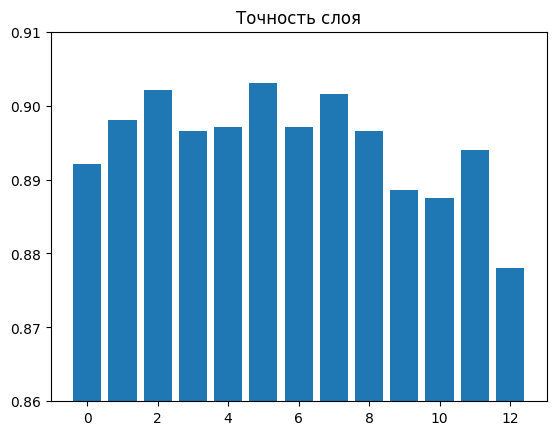

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
plt.ylim(0.86, 0.91)
plt.show()

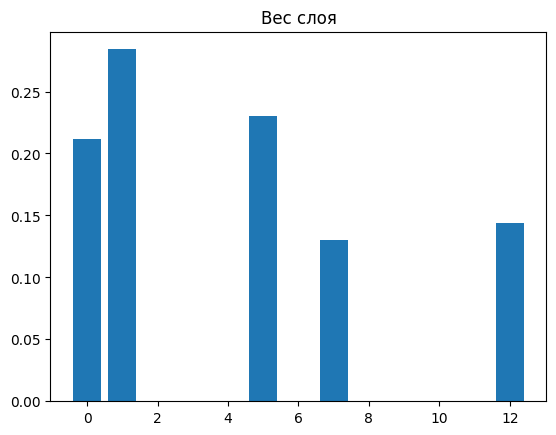

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "layer_qp_mean_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7010064935064935
CPU times: user 29.8 s, sys: 1.17 s, total: 31 s
Wall time: 43.2 s


## QP nonsym

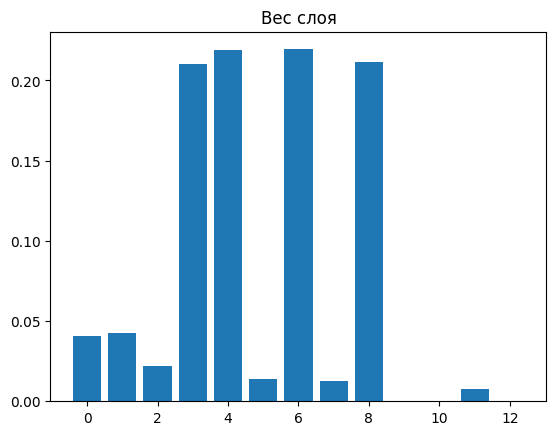

In [31]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [32]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

train.jsonl:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/365k [00:00<?, ?B/s]

main_score =  0.6940584415584417
CPU times: user 28.6 s, sys: 204 ms, total: 28.8 s
Wall time: 43.3 s


## PCA сlusters

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


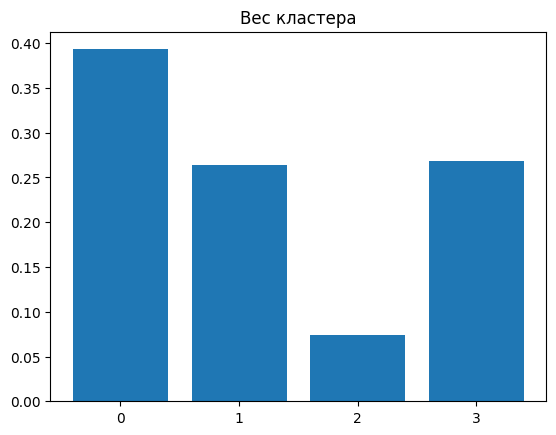

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA для задачи: Banking77Classification ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_divercity_Banking77Classification.pt


In [ ]:
CKPT_PATH  = PATH + f"pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

<ipython-input-47-103fc8e663e7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_cluster_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6273701298701299


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 32

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 1, 5, 7, 12] ===


  0%|          | 0/938 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_Banking77Classification.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_qp_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7081818181818182


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

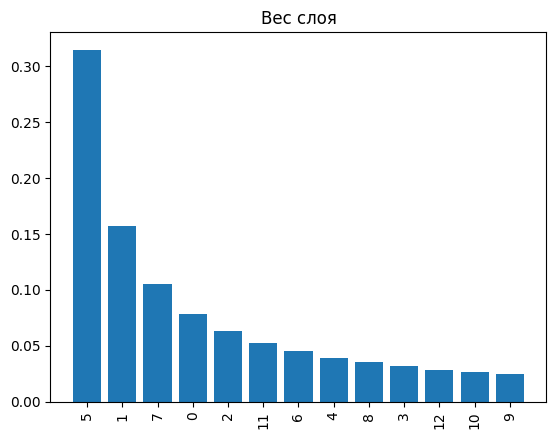

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "greedy_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7106493506493508


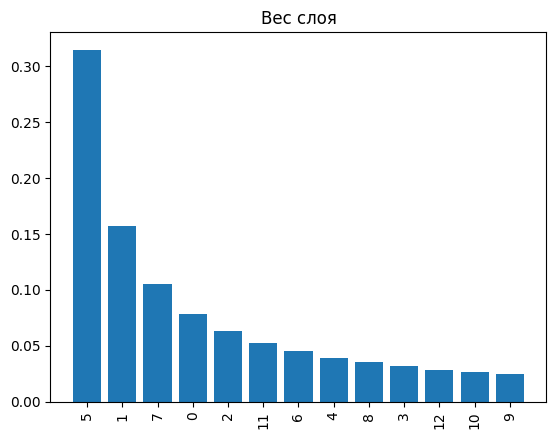

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder= BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

train.jsonl:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/365k [00:00<?, ?B/s]

main_score =  0.697077922077922


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH + "/last_mean_mask_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH + "best_dev_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH + "layer_qp_mean_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH + "concat_pca_cluster_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH + "concat_pca_qp_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH + "greedy_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.629968,0.672955,0.701006,0.62737,0.708182,0.710649


# TweetSentimentExtractionClassification

In [33]:
task_names = ['TweetSentimentExtractionClassification']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + f'layer_{task_names[0]}'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/tweet_sentiment_extraction")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 700)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/195k [00:00<?, ?B/s]


>>> Layer 0
Accuracy: 0.6884

>>> Layer 1
Accuracy: 0.6898

>>> Layer 2
Accuracy: 0.6840

>>> Layer 3
Accuracy: 0.6793

>>> Layer 4
Accuracy: 0.6787

>>> Layer 5
Accuracy: 0.6827

>>> Layer 6
Accuracy: 0.6853

>>> Layer 7
Accuracy: 0.6922

>>> Layer 8
Accuracy: 0.6980

>>> Layer 9
Accuracy: 0.6957

>>> Layer 10
Accuracy: 0.6957

>>> Layer 11
Accuracy: 0.6898

>>> Layer 12
Accuracy: 0.6875


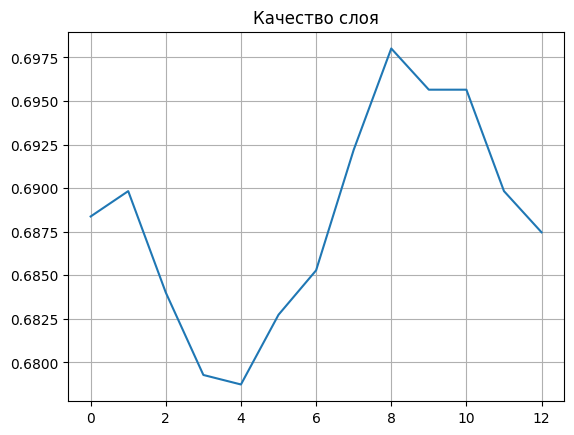

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i['accuracy'] for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5193831352574987
CPU times: user 20.9 s, sys: 781 ms, total: 21.6 s
Wall time: 24.1 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5275042444821731
CPU times: user 27.2 s, sys: 173 ms, total: 27.4 s
Wall time: 19.6 s


## Взвешанное среднее

In [34]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

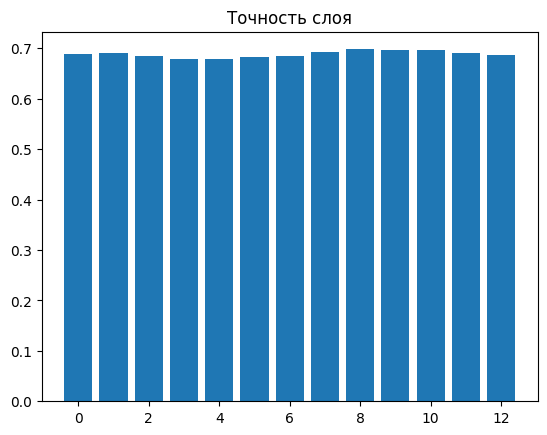

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.91)
plt.show()

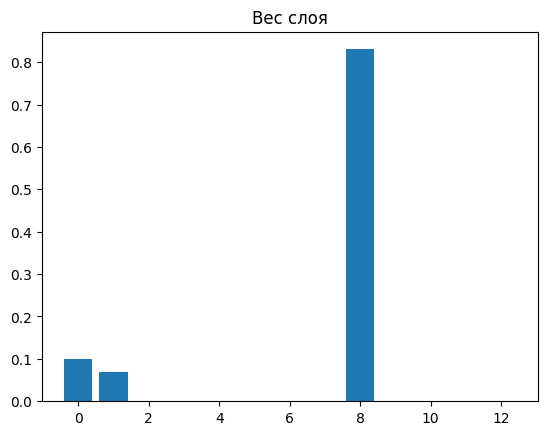

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

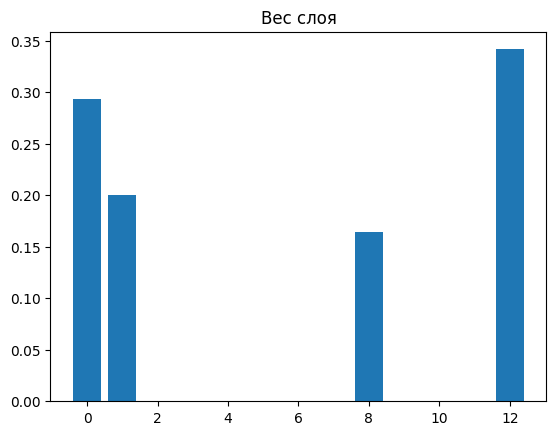

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.530192416525184
CPU times: user 21.1 s, sys: 159 ms, total: 21.2 s
Wall time: 12.2 s


## QP nonsym

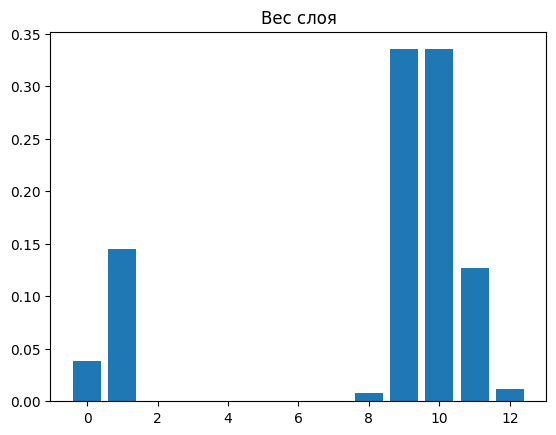

In [35]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [36]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5473967176004528
CPU times: user 20.1 s, sys: 136 ms, total: 20.3 s
Wall time: 16.4 s


## PCA clusters +

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


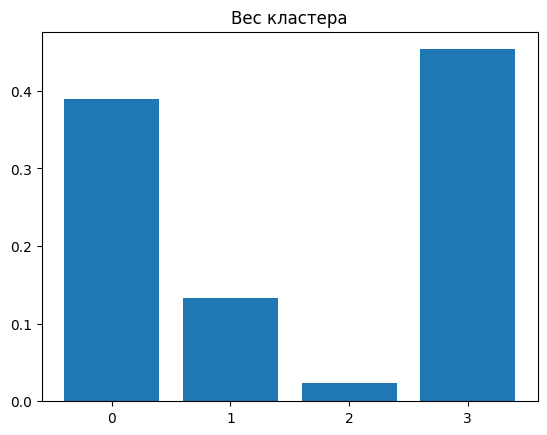

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128
HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA для задачи: TweetSentimentExtractionClassification ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_divercity_TweetSentimentExtractionClassification.pt


In [ ]:
# CKPT_PATH  = PATH + f"/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5144595359366158


## PCA QP +

In [ ]:
weights_idx, final_acc

(array([ 0,  1,  8, 12]),
 array([0.29351006, 0.20074977, 0.1639131 , 0.34182707]))

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 256
HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA по отобранным слоям: [0, 1, 8, 12] ===


  0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_TweetSentimentExtractionClassification.pt


In [ ]:
# ckpt = torch.load(out_path)

<ipython-input-80-1c473d74d051>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(out_path)


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5413978494623656


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

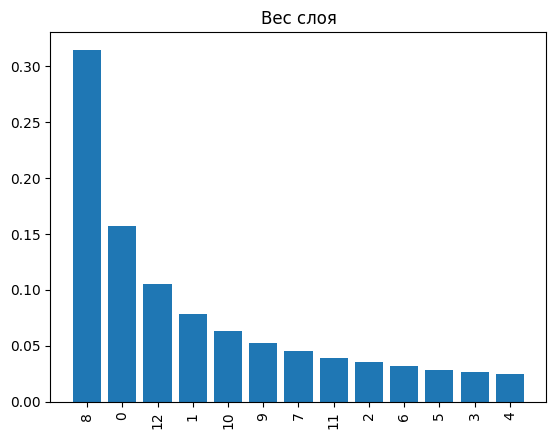

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5358517260894171


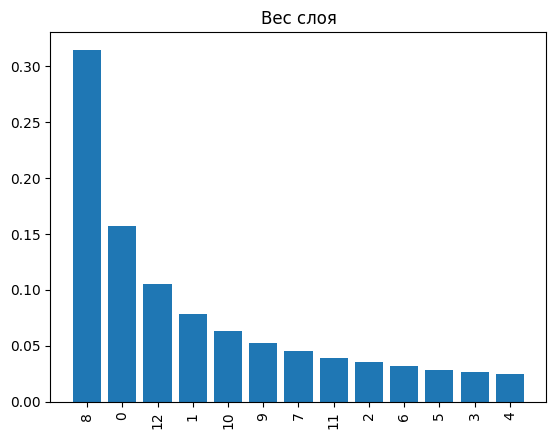

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.548104131295982


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.519383,0.527504,0.530192,0.504867,0.533588,0.535852


# NFCorpus

In [37]:
task_names = ['NFCorpus']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев dev

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/nfcorpus")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/nfcorpus", name="queries", split="queries")
corpus  = load_dataset("mteb/nfcorpus", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'


results = {}
for layer in range(13):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_nfcorpus(
        encoder=encoder,
        queries=queries_dev,
        corpus=corpus_dev,
        relevance=relevance_dev,
        top_k=10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0
0.26851851851851855
→ Layer 1
0.3765432098765432
→ Layer 2
0.32098765432098764
→ Layer 3
0.23765432098765432
→ Layer 4
0.18518518518518517
→ Layer 5
0.16358024691358025
→ Layer 6
0.1419753086419753
→ Layer 7
0.1419753086419753
→ Layer 8
0.14814814814814814
→ Layer 9
0.1697530864197531
→ Layer 10
0.18518518518518517
→ Layer 11
0.2716049382716049
→ Layer 12
0.2839506172839506


In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'
res = load_res(PATH)

In [ ]:
best_layer = np.argmax(list(res.values())).item()
best_layer

1

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.01279
CPU times: user 24.6 s, sys: 124 ms, total: 24.7 s
Wall time: 29.7 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03888
CPU times: user 24.6 s, sys: 139 ms, total: 24.7 s
Wall time: 29.9 s


## Взвешанное среднее

In [38]:
layer_acc = load_res(BASE_PATH+f'layer_{task_names[0]}')
acc = np.array(list(layer_acc.values()))

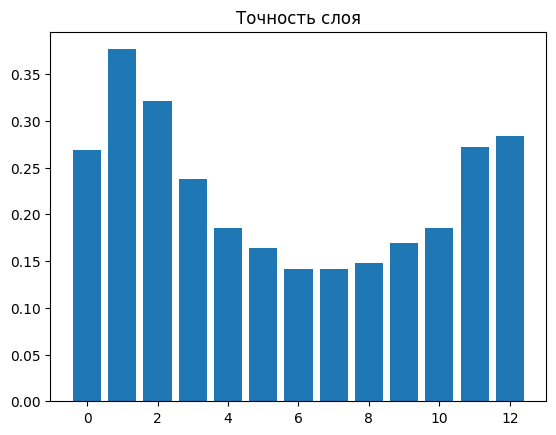

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.91)
plt.show()

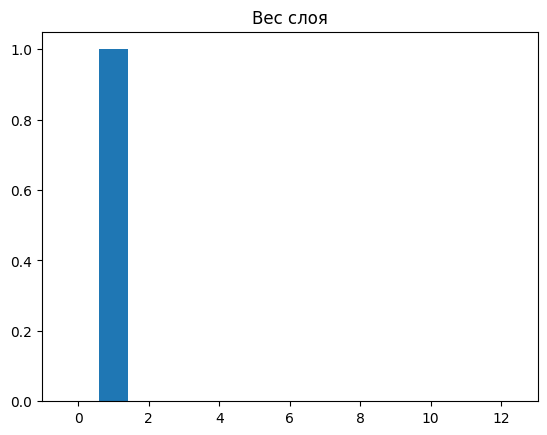

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
len(final_acc)

1

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03888
CPU times: user 25 s, sys: 143 ms, total: 25.1 s
Wall time: 30 s


## QP nonsym

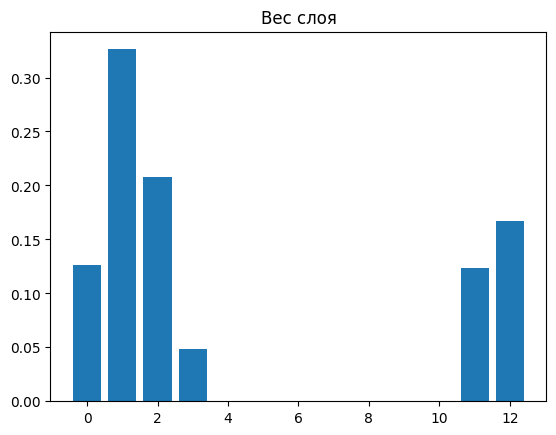

In [39]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [40]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

main_score =  0.02215
CPU times: user 25.3 s, sys: 177 ms, total: 25.5 s
Wall time: 38.7 s


## PCA cluster

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


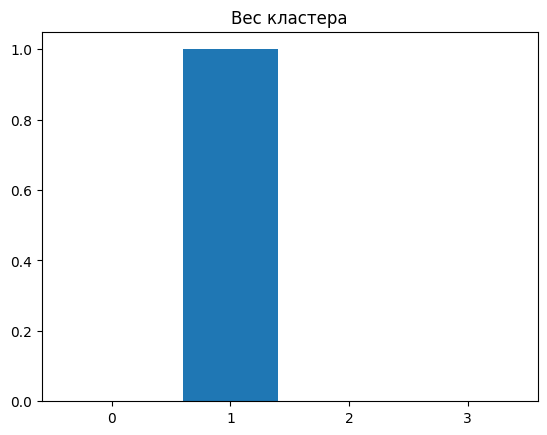

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128
HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA для задачи: NFCorpus ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_divercity_NFCorpus.pt


In [ ]:
# CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.02598


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA по отобранным слоям: [1] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_NFCorpus.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.0379


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

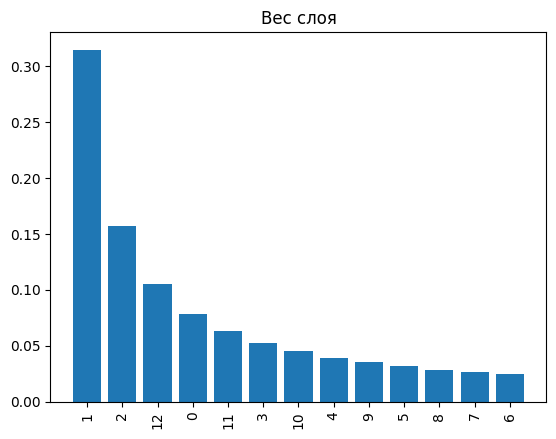

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="ddd",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.02048


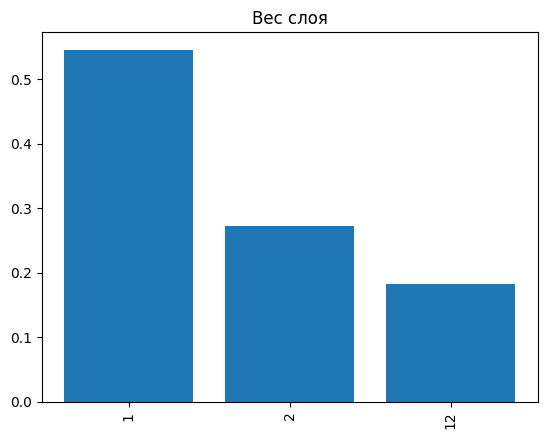

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 3)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

чит, выбрал 3 слоя

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.0254


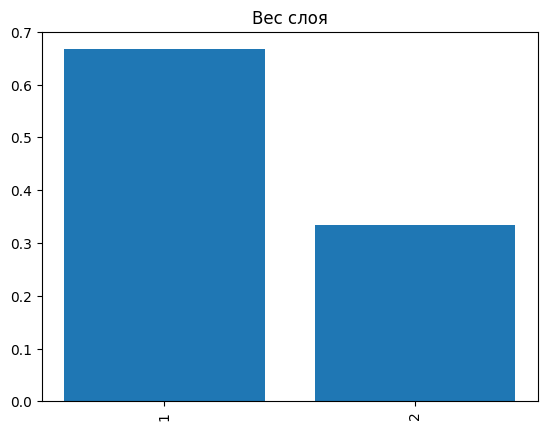

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

main_score =  0.03028


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.01279,0.12746,0.12746,0.02942,0.10886,0.09193


# QuoraRetrieval

In [24]:
task_names = ['QuoraRetrieval']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

In [25]:
# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )

## Качество отдельных слоев на dev

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/quora")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/quora", name="queries", split="queries")
corpus  = load_dataset("mteb/quora", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

In [ ]:
# queries_dev

In [ ]:
PATH = BASE_PATH + f'/layer_{task_names[0]}'


results = {}
for layer in range(13):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_ndcg(
    encoder=encoder,
    queries=queries_dev,
    corpus=corpus_dev,
    relevance=relevance_dev,
    top_k=10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0
0.8843201830170687
→ Layer 1
0.9340758917976686
→ Layer 2
0.9330867904111386
→ Layer 3
0.9135288277006719
→ Layer 4
0.8987789181623419
→ Layer 5
0.8937456432329247
→ Layer 6
0.8757534991635506
→ Layer 7
0.8723347499991935
→ Layer 8
0.8516071436404214
→ Layer 9
0.8345822641149014
→ Layer 10
0.8691485332696504
→ Layer 11
0.8749782060563451
→ Layer 12
0.8846985728534641


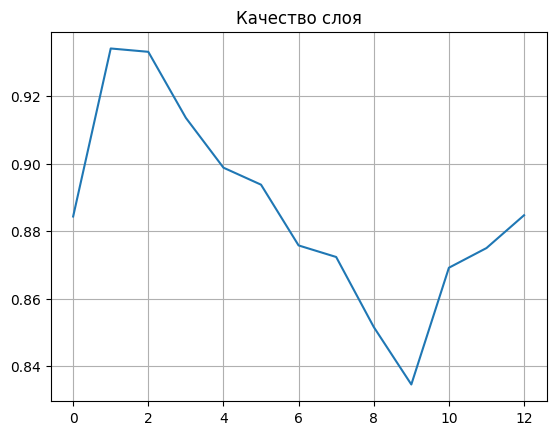

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.54244
CPU times: user 18min 59s, sys: 48.4 s, total: 19min 47s
Wall time: 17min 20s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.62354
CPU times: user 18min 54s, sys: 42.5 s, total: 19min 37s
Wall time: 17min 12s


## Взвешанное среднее

In [26]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

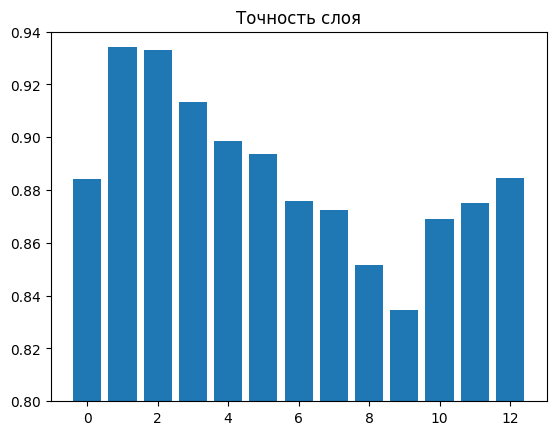

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
plt.ylim(0.80, 0.94)
plt.show()

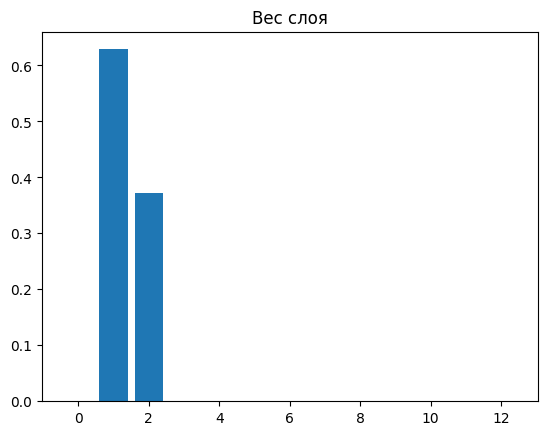

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

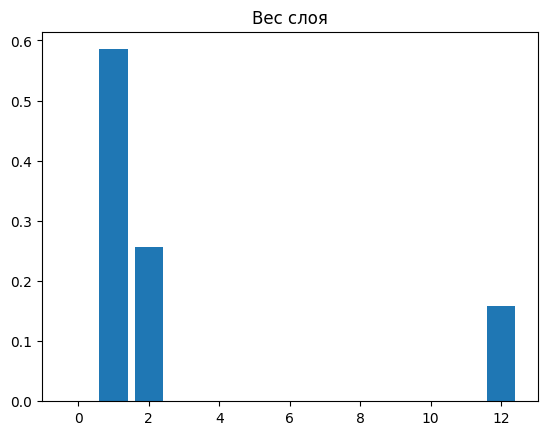

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.63418
CPU times: user 19min 2s, sys: 42.9 s, total: 19min 45s
Wall time: 17min 20s


## QP nonsym

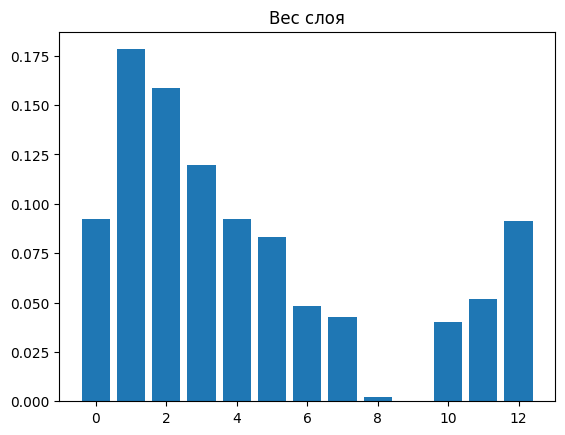

In [27]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [28]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.63747
CPU times: user 18min 17s, sys: 49 s, total: 19min 6s
Wall time: 16min 50s


## PCA cluster

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


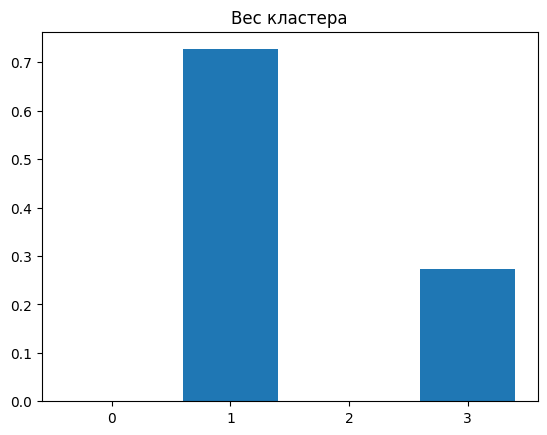

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA для задачи: QuoraRetrieval ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_divercity_QuoraRetrieval.pt


In [ ]:
# CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.64229


##PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA по отобранным слоям: [1, 2, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_QuoraRetrieval.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.63668


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

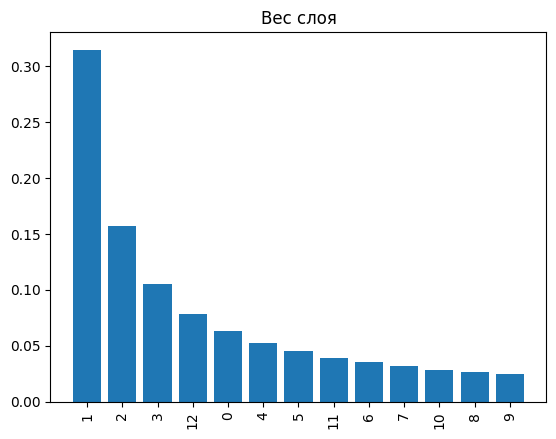

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.64502


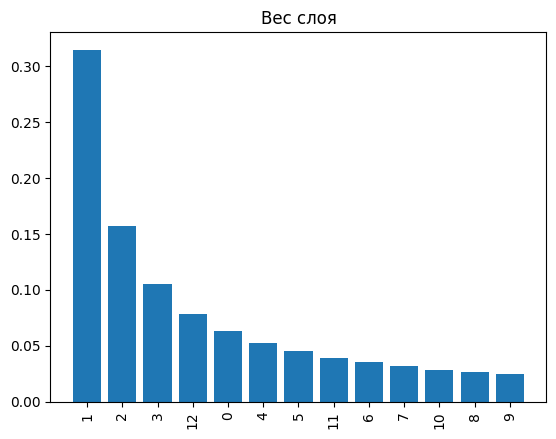

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.64502


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.54244,0.62354,0.63418,0.64229,0.63668,0.64502


In [ ]:
from google.colab import runtime
runtime.unassign()

# STSBenchmark

In [24]:
task_names = ['STSBenchmark']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
ds = load_dataset("mteb/stsbenchmark-sts")
dev = ds["validation"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.67k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    spearman = evaluate_layer_spearman(encoder, dev)
    print(f"Spearman = {spearman:.4f}")

    results[layer] = spearman
    save_res(results, PATH)


>>> Layer 0


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.5851

>>> Layer 1


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.5814

>>> Layer 2


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6128

>>> Layer 3


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6507

>>> Layer 4


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6486

>>> Layer 5


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6434

>>> Layer 6


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6335

>>> Layer 7


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6669

>>> Layer 8


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6614

>>> Layer 9


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6597

>>> Layer 10


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6509

>>> Layer 11


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6618

>>> Layer 12


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Spearman = 0.6500


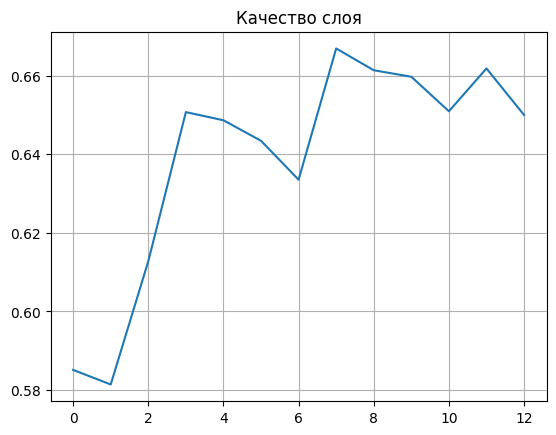

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5435537028944825
CPU times: user 3.3 s, sys: 121 ms, total: 3.42 s
Wall time: 7.86 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5512660288584921
CPU times: user 3.24 s, sys: 88.4 ms, total: 3.32 s
Wall time: 7.23 s


## Взвешанное среднее

In [28]:
layer_acc = load_res(BASE_PATH+f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

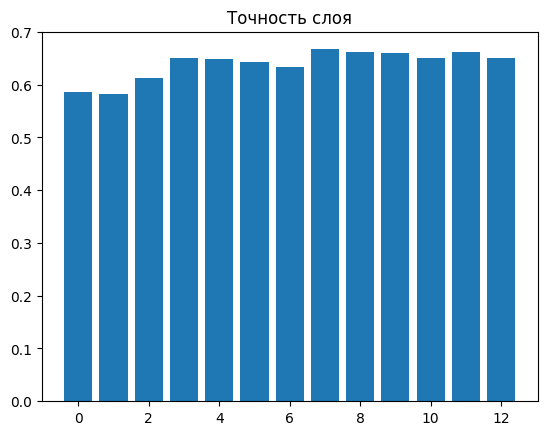

In [29]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

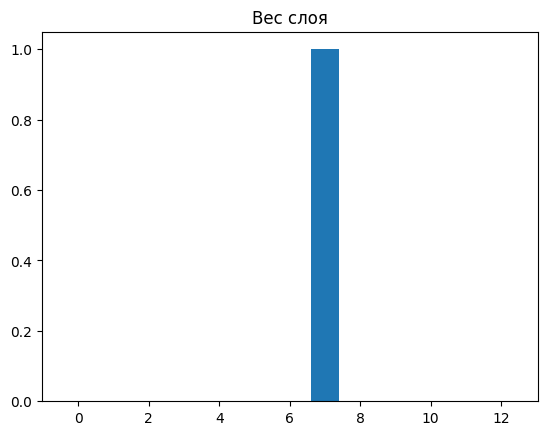

In [30]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

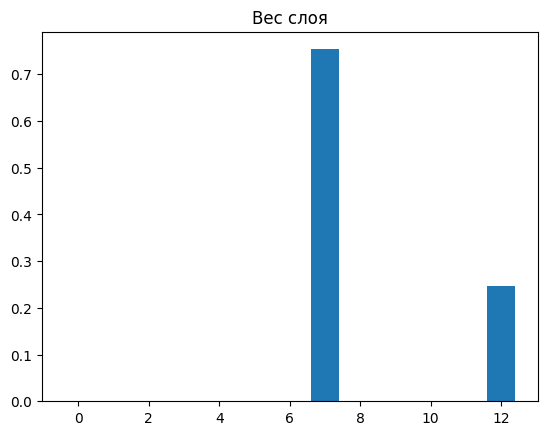

In [31]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [33]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH+f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5575266075610419
CPU times: user 3.25 s, sys: 85.2 ms, total: 3.33 s
Wall time: 6.08 s


## QP nonsym

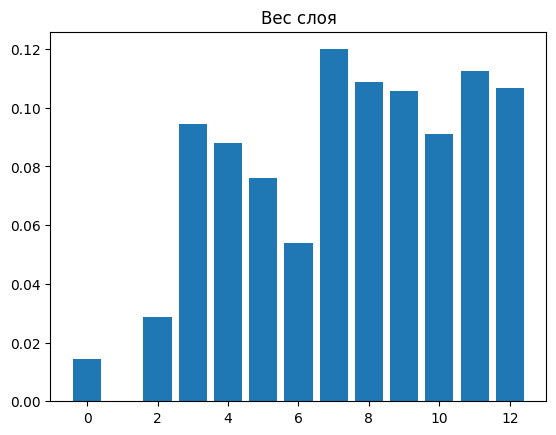

In [43]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [44]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

main_score =  0.5707209539334586
CPU times: user 3.64 s, sys: 110 ms, total: 3.75 s
Wall time: 12.5 s


## PCA cluster

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


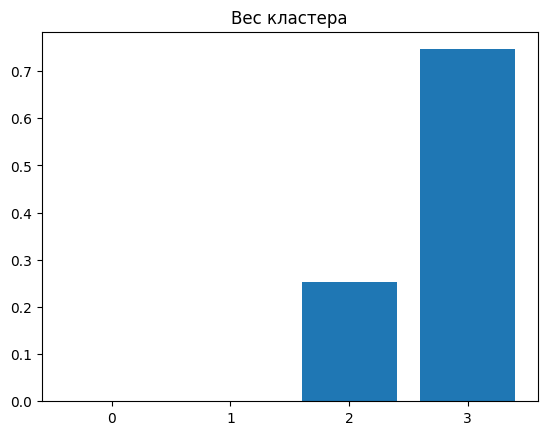

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH+'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128
HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA для задачи: STSBenchmark ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_divercity_STSBenchmark.pt


In [ ]:
ckpt = torch.load(BASE_PATH+  f"PCA/pca_divercity_{task_names[0]}.pt")

In [ ]:
 encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5523563657799625


## PCA qp

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128
HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA по отобранным слоям: [7, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_STSBenchmark.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5493799596306397


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

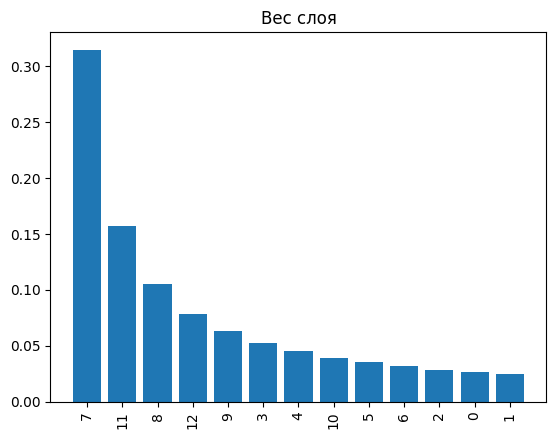

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5710043934824761


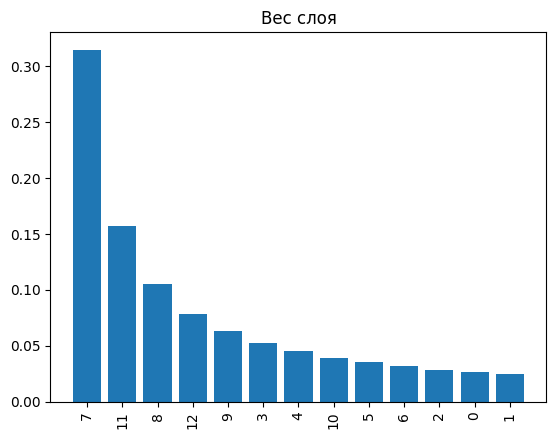

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

main_score =  0.5710043934824761


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

# SprintDuplicateQuestions +

In [45]:
task_names = ['SprintDuplicateQuestions']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
dataset = load_dataset("mteb/sprintduplicatequestions-pairclassification", split="validation")

README.md:   0%|          | 0.00/7.69k [00:00<?, ?B/s]

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

results = {}
# results = load_res(PATH)

for layer in range(13):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    ap = evaluate_layer_ap(encoder, dataset)
    print(f"AP = {ap:.4f}")
    results[layer] = ap
    save_res(results, PATH)


>>> Layer 0


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.4717

>>> Layer 1


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3829

>>> Layer 2


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.4240

>>> Layer 3


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.4135

>>> Layer 4


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.4028

>>> Layer 5


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3502

>>> Layer 6


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3310

>>> Layer 7


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3369

>>> Layer 8


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3172

>>> Layer 9


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3157

>>> Layer 10


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.2955

>>> Layer 11


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.2790

>>> Layer 12


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AP = 0.3141


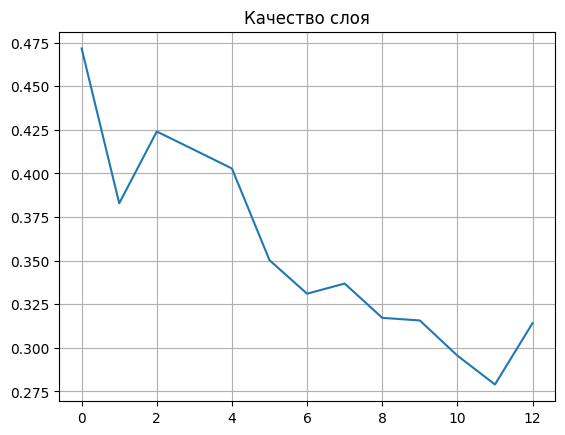

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.49482682504610187
CPU times: user 15.6 s, sys: 602 ms, total: 16.2 s
Wall time: 18 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = 'yyyy',
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.5771426507094599
CPU times: user 11.7 s, sys: 794 ms, total: 12.5 s
Wall time: 15.5 s


In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

## Взвешанное среднее

In [46]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

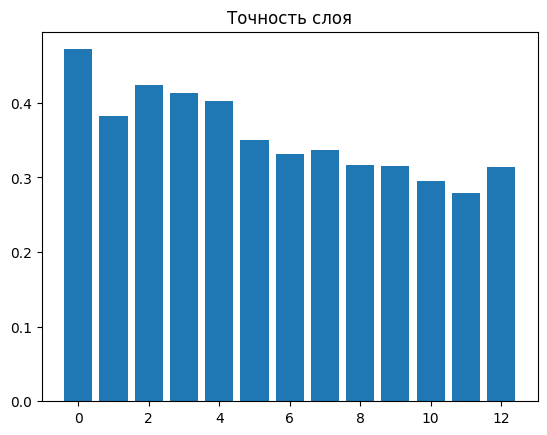

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

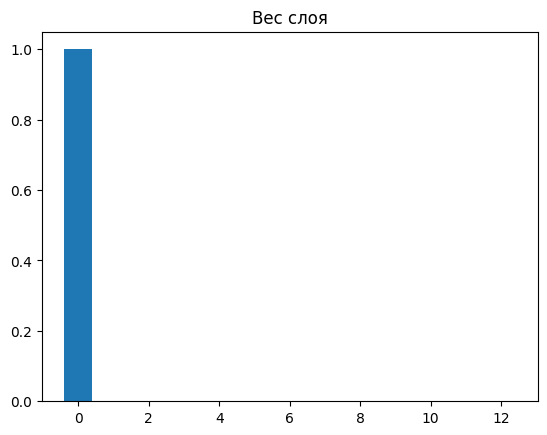

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

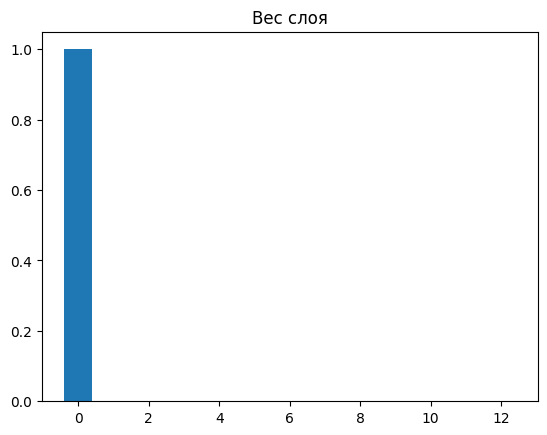

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.5771426507094599
CPU times: user 15.8 s, sys: 588 ms, total: 16.4 s
Wall time: 17.3 s


## QP nonsym

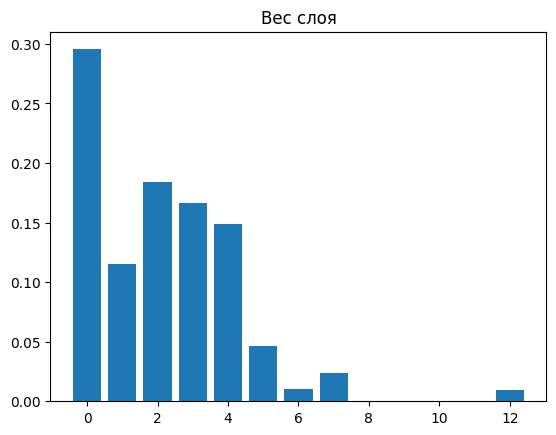

In [47]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [48]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.5689795578731851
CPU times: user 16.4 s, sys: 654 ms, total: 17.1 s
Wall time: 24.6 s


## PCA cluster +

CLUSTERS:  [[0], [1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11], [12]]


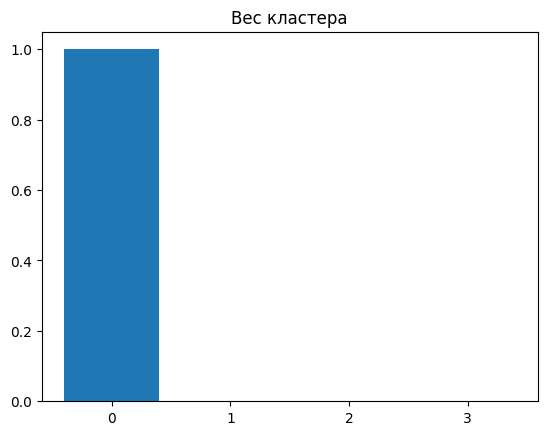

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

In [ ]:
CKPT_PATH  = BASE_PATH + f"PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7190122440622962


## PCA qp +

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Обучение PCA по отобранным слоям: [0] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_SprintDuplicateQuestions.pt


In [ ]:
CKPT_PATH  = '/content/drive/MyDrive/PTLS/NLP/ROBERTA/PCA/pca_qadr_layers_SprintDuplicateQuestions.pt'
ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
# ckpt['mean']

In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7190120990710844


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.5737445846589391


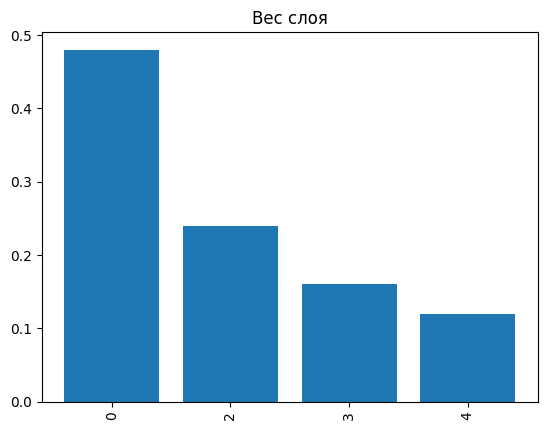

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.5647792902103576


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.54244,0.62354,0.63418,0.64229,0.63668,0.64502


# Результаты по всем задачам

In [ ]:
import pandas as pd
import json
from google.colab import drive
drive.mount('/content/drive/')
BASE_PATH = '/content/drive/MyDrive/PTLS/NLP/ROBERTA/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
def load_row(task_name):

  dct_res = {}

  with open(BASE_PATH + f"last_mean_mask_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['last_mean'] = best

  with open(BASE_PATH + f"best_dev_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['best_layer'] = best

  with open(BASE_PATH + f"layer_qp_mean_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['weighted_mean_qp'] = best

  with open(BASE_PATH + f"concat_pca_cluster_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_cluster'] = best

  with open(BASE_PATH + f"concat_pca_qp_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_qp'] = best

  with open(BASE_PATH + f"greedy_v3_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['greedy'] = best

  with open(BASE_PATH + f"layer_qp_nonsym_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['qp_nonsym'] = best

  return dct_res

In [51]:
task_names = ['Banking77Classification', 'TweetSentimentExtractionClassification', 'NFCorpus', 'QuoraRetrieval', 'STSBenchmark', 'SprintDuplicateQuestions']

In [52]:
all_res = []
for task in task_names:
  all_res.append(load_row(task))

In [53]:
df = pd.DataFrame(all_res, index=task_names)

In [54]:
df

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy,qp_nonsym
Banking77Classification,0.629968,0.672955,0.701006,0.627370,0.708182,0.697078,0.694058
TweetSentimentExtractionClassification,0.519383,0.527504,0.530192,0.514460,0.541398,0.548104,0.547397
NFCorpus,0.012790,0.038880,0.038880,0.025980,0.037900,0.030280,0.022150
QuoraRetrieval,0.542440,0.623540,0.634180,0.642290,0.636680,0.645020,0.637470
STSBenchmark,0.543554,0.551266,0.557527,0.552356,0.549380,0.571004,0.570721
SprintDuplicateQuestions,0.494827,0.577143,0.577143,0.719012,0.719012,0.564779,0.568980


в STSBenchmark pca не стреляет тк там из одного слоя: кластер только с нулевым элементом и метод qp отобрал только один элемент\
в NFCorpus тоже отобран только один слой + один кластер с [1,2] \
в quora retrieval отобралось 3 слоя


In [55]:
df.to_csv(BASE_PATH +'ROBERTA_final_results_1.csv')